##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pruning in Keras example

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/model-optimization/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

Welcome to an end-to-end example for magnitude-based *weight pruning*.

### Other pages
For an introduction to what pruning is and to determine if you should use it (including what's supported), see the [overview page](https://www.tensorflow.org/model_optimization/guide/pruning).

To quickly find the APIs you need for your use case (beyond fully pruning a model with 80% sparsity), see the
[comprehensive guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md).

### Summary

In this tutorial, you will:

1.   Train a `tf.keras` model for MNIST from scratch.
2.   Fine tune the model by applying the pruning API and see the accuracy.
3.   Create 3x smaller TF and TFLite models from pruning.
4.   Create a 10x smaller TFLite model from combining pruning and post-training quantization.
5.   See the persistence of accuracy from TF to TFLite.

## Setup

In [84]:
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [17]:
import tempfile
import os
from datetime import datetime

import tensorflow as tf
import numpy as np

import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Train a model for MNIST without pruning

In [21]:
# Load MNIST dataset
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
if 0:
    model = keras.Sequential([
      keras.layers.InputLayer(input_shape=(28, 28)),
      keras.layers.Reshape(target_shape=(28, 28, 1)),
      keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Flatten(),
      keras.layers.Dense(100),
      keras.layers.Dense(10)
    ])
    
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(5,5), activation='relu', name="c0"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
   keras.layers.Dense(400, activation="relu",name="l1"),
  keras.layers.Dense(10,activation='softmax',name="l0")
])

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=8,
  validation_split=0.1,
             callbacks=[tensorboard_callback]
)

Epoch 1/8
1688/1688 [==============================] - 54s 32ms/step - loss: 1.6548 - accuracy: 0.8109 - val_loss: 1.6146 - val_accuracy: 0.8462
Epoch 2/8
1688/1688 [==============================] - 56s 33ms/step - loss: 1.5914 - accuracy: 0.8710 - val_loss: 1.5924 - val_accuracy: 0.8690
Epoch 3/8
1688/1688 [==============================] - 56s 33ms/step - loss: 1.5777 - accuracy: 0.8840 - val_loss: 1.5778 - val_accuracy: 0.8845
Epoch 4/8
1688/1688 [==============================] - 49s 29ms/step - loss: 1.5698 - accuracy: 0.8922 - val_loss: 1.5723 - val_accuracy: 0.8887
Epoch 5/8
1688/1688 [==============================] - 55s 33ms/step - loss: 1.5646 - accuracy: 0.8967 - val_loss: 1.5776 - val_accuracy: 0.8835
Epoch 6/8
1688/1688 [==============================] - 55s 32ms/step - loss: 1.5583 - accuracy: 0.9027 - val_loss: 1.5780 - val_accuracy: 0.8825
Epoch 7/8
1688/1688 [==============================] - 50s 29ms/step - loss: 1.5530 - accuracy: 0.9085 - val_loss: 1.5705 - val_ac

In [ ]:
model.summary()

Evaluate baseline test accuracy and save the model for later usage.

In [24]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.8973000049591064
Saved baseline model to: /tmp/tmp6iaoir4f.h5


## Fine-tune pre-trained model with pruning


### Define the model

You will apply pruning to the whole model and see this in the model summary.

In this example, you start the model with 50% sparsity (50% zeros in weights)
and end with 80% sparsity.

In the [comprehensive guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md), you can see how to prune some layers for model accuracy improvements.

In [25]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 4
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params_c0 = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.9,
                                                               begin_step=0,
                                                               end_step=end_step)
}
pruning_params_l2 = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.999,
                                                               begin_step=0,
                                                               end_step=end_step)
}
pruning_params_l1 = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.999,
                                                               begin_step=0,
                                                               end_step=end_step)
}
pruning_params_l0 = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.99,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_selected(layer):
    if layer.name=="c0":
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params_c0)
    if layer.name=="l1":
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params_l1)
    if layer.name=="l2":
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params_l2)
    if layer.name=="l0":
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params_l0)
    return layer

model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_selected,
)

#model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
prune_low_magnitude_c0 (Prun (None, 24, 24, 12)        614       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 12)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1728)              0         
_________________________________________________________________
prune_low_magnitude_l1 (Prun (None, 400)               1382802   
_________________________________________________________________
prune_low_magnitude_l0 (Prun (None, 10)                8012      
Total params: 1,391,428
Trainable params: 695,922
Non-trainable params: 695,506
________________________________________

### Train and evaluate the model against baseline

Fine tune with pruning for two epochs.

`tfmot.sparsity.keras.UpdatePruningStep` is required during training, and `tfmot.sparsity.keras.PruningSummaries` provides logs for tracking progress and debugging.

In [26]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/4
  2/422 [..............................] - ETA: 45s - loss: 1.5697 - accuracy: 0.8867WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0686s vs `on_train_batch_end` time: 0.1457s). Check your callbacks.


422/422 [==============================] - 31s 73ms/step - loss: 1.5477 - accuracy: 0.9159 - val_loss: 1.5742 - val_accuracy: 0.8922
Epoch 2/4
422/422 [==============================] - 33s 78ms/step - loss: 1.5769 - accuracy: 0.8946 - val_loss: 1.5974 - val_accuracy: 0.8757
Epoch 3/4
422/422 [==============================] - 33s 78ms/step - loss: 1.6490 - accuracy: 0.8381 - val_loss: 1.6768 - val_accuracy: 0.8217
Epoch 4/4
422/422 [==============================] - 38s 91ms/step - loss: 1.7166 - accuracy: 0.7839 - val_loss: 1.6981 - val_accuracy: 0.8010


For this example, there is minimal loss in test accuracy after pruning, compared to the baseline.

In [27]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.8973000049591064
Pruned test accuracy: 0.7922000288963318


The logs show the progression of sparsity on a per-layer basis.

In [20]:
#docs_infra: no_execute
%tensorboard --logdir={logdir}

For non-Colab users, you can see [the results of a previous run](https://tensorboard.dev/experiment/sRQnrycaTMWQOaswXzClYA/#scalars&_smoothingWeight=0) of this code block on [TensorBoard.dev](https://tensorboard.dev/).

## Create 3x smaller models from pruning

Both `tfmot.sparsity.keras.strip_pruning` and applying a standard compression algorithm (e.g. via gzip) are necessary to see the compression
benefits of pruning.

*   `strip_pruning` is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to model size during inference
*   Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is
added redundancy that algorithms can utilize to further compress the model.

First, create a compressible model for TensorFlow.

In [28]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmp37coapz1.h5


Then, create a compressible model for TFLite.

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpxkkzn64s/assets


INFO:tensorflow:Assets written to: /tmp/tmpxkkzn64s/assets


Saved pruned TFLite model to: /tmp/tmpr0eu53yw.tflite


Define a helper function to actually compress the models via gzip and measure the zipped size.

In [30]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

Compare and see that the models are 3x smaller from pruning.

In [31]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 2595654.00 bytes
Size of gzipped pruned Keras model: 195067.00 bytes
Size of gzipped pruned TFlite model: 165927.00 bytes


## Create a 10x smaller model from combining pruning and quantization

You can apply post-training quantization to the pruned model for additional benefits.

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: /tmp/tmpmzjqdgmi/assets


INFO:tensorflow:Assets written to: /tmp/tmpmzjqdgmi/assets


Saved quantized and pruned TFLite model to: /tmp/tmpxxoe398n.tflite
Size of gzipped baseline Keras model: 2595654.00 bytes
Size of gzipped pruned and quantized TFlite model: 7592.00 bytes


## See persistence of accuracy from TF to TFLite

Define a helper function to evaluate the TF Lite model on the test dataset.

In [33]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

You evaluate the pruned and quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [78]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)
print('Pruned TF test accuracy:', model_for_pruning_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Pruned and quantized TFLite test_accuracy: 0.847
Pruned TF test accuracy: 0.8464000225067139


## Conclusion

In [18]:
model.layers

In [79]:
model.layers[5].weights

[<tf.Variable 'l0/kernel:0' shape=(400, 10) dtype=float32, numpy=
 array([[ 0.       ,  0.7075751, -0.       , ..., -0.       , -0.       ,
         -0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       , -0.       ,
          0.       ],
        [-0.       ,  0.       ,  0.       , ..., -0.       ,  0.       ,
         -0.       ],
        ...,
        [ 0.       , -0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [-0.       , -0.       , -0.       , ..., -0.       , -0.       ,
         -0.       ],
        [ 0.       , -0.       ,  0.       , ..., -0.       ,  0.       ,
         -0.       ]], dtype=float32)>,
 <tf.Variable 'l0/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.34153175, -0.84797037,  0.6178334 , -0.10211604, -4.0805483 ,
        -0.3694042 , -0.21163541,  0.8321205 , -0.05734215, -0.21053283],
       dtype=float32)>]

In [97]:
for i in range(len(model.layers)):
    l=model.layers[i]
    if len(l.weights) > 0:
        w=l.weights[0].numpy()
        print("{}, in avg={}, std={}, max={}, out avg={}, std={}, max={}".format(
            i,
            np.average(sum(w!=0)),
            np.std(sum(w!=0)),
            np.max(sum(w!=0)),
            (np.average(sum(w.transpose()!=0))),
            (np.std(sum(w.transpose()!=0))),
               (np.max(sum(w.transpose()!=0)))
        ))

1, in avg=0.5, std=1.118033988749895, max=4, out avg=1.2, std=0.9797958971132713, max=3
4, in avg=1.85, std=8.800994262013809, max=68, out avg=0.42824074074074076, std=1.119353590498737, max=10
5, in avg=4.0, std=1.2649110640673518, max=6, out avg=0.1, std=0.4743416490252569, max=4


In [62]:
model.layers[1].weights[0].numpy()

array([[ 0., -0., -0., ...,  0., -0.,  0.],
       [ 0., -0.,  0., ..., -0., -0.,  0.],
       [ 0., -0.,  0., ...,  0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0.,  0., ...,  0., -0.,  0.]], dtype=float32)

In [132]:
w[0].numpy()

array([[-0.,  0.,  0., ...,  0., -0.,  0.],
       [-0.,  0.,  0., ...,  0.,  0., -0.],
       [ 0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0.,  0., ..., -0.,  0., -0.],
       [-0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0., -0.,  0.]], dtype=float32)

In [36]:
import matplotlib.pylab as plt
import scipy.sparse as sparse

In [44]:
model.layers[4].weights[0].numpy().shape

(1728, 400)

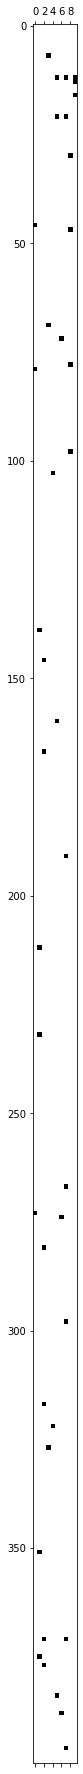

In [40]:
fig=plt.figure(figsize=(12,32))
plt.spy(model.layers[5].weights[0].numpy())

In [35]:
fig=plt.figure(figsize=(12,32))
plt.spy(model.layers[5].weights[0].numpy())

NameError: name 'plt' is not defined

In [49]:
model.layers[5].weights[0]

<tf.Variable 'l0/kernel:0' shape=(400, 10) dtype=float32, numpy=
array([[ 0.14873005, -0.05939085,  0.09473985, ..., -0.2242427 ,
         0.09320899,  0.06813481],
       [ 0.3115249 ,  0.12719092, -0.34525675, ...,  0.03770339,
         0.18651219, -0.19702742],
       [-0.07720623,  0.33117342,  0.02835927, ..., -0.3686388 ,
        -0.1766202 ,  0.32385835],
       ...,
       [-0.23221527, -0.1479641 , -0.0590368 , ...,  0.08598855,
         0.14343278,  0.07206908],
       [ 0.21923101, -0.41211462, -0.29207748, ..., -0.1541255 ,
        -0.10055155, -0.1178807 ],
       [ 0.08779467, -0.12240529,  0.0842476 , ..., -0.14257678,
        -0.29477966,  0.25619465]], dtype=float32)>

In [4]:
plt.imshow(sum((model.layers[1].weights[0].numpy().transpose()!=0)).reshape((28,28)))

NameError: name 'plt' is not defined

In [37]:
28*28

784

In this tutorial, you saw how to create sparse models with the TensorFlow Model Optimization Toolkit API for both TensorFlow and TFLite. You 
then combined pruning with post-training quantization for additional benefits.

You created a 10x smaller model for MNIST, with minimal accuracy difference.

We encourage you to try this new capability, which can be particularly important for deployment in resource-constrained environments.


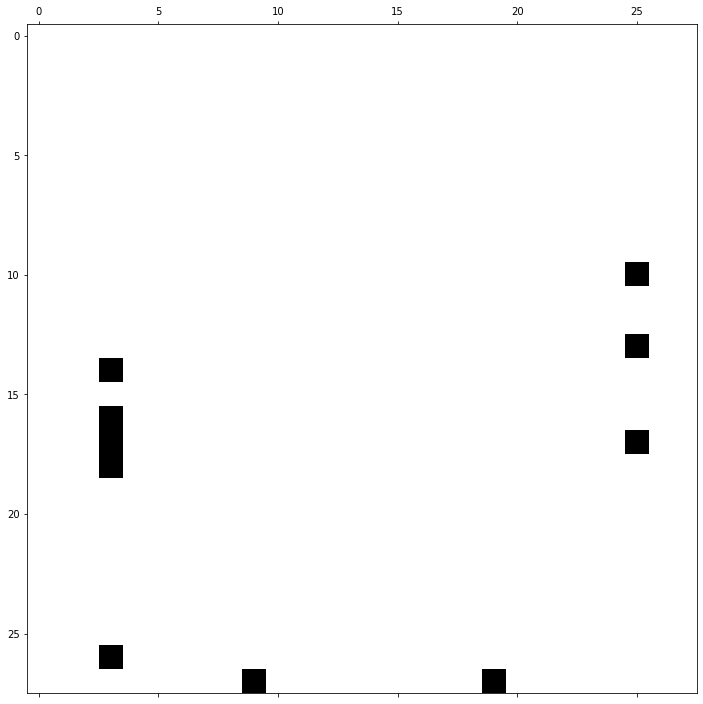

In [395]:
fig=plt.figure(figsize=(12,17))
plt.spy(wws[:,:,10])

In [169]:
def render_as_graph(layers,input_shape):
    curr=np.array([
        [
            f"i_{x}_{y}" for x in range(input_shape[1])
        ] for y in range(input_shape[0])
    ], dtype=object)
    for i in range(len(layers)):
        l=layers[i]
        si=l.input_shape
        assert si[0]==None
        si=si[1:]
        so=l.output_shape
        assert so[0] is None
        so=so[1:]
        if isinstance(l,keras.layers.Reshape):
            curr=np.reshape(curr, so)
        elif isinstance(l,keras.layers.Conv2D):
            assert l.activation==keras.activations.relu, f"Activation={l.activation}"
            assert l.use_bias==True
            assert l.padding=="valid"
            assert l.data_format=="channels_last"
            assert l.strides==(1,1)
            assert l.dilation_rate==(1,1)
            assert l.groups==1
            kernel_size=l.kernel_size
            filters=l.filters
            weights=l.weights[0].numpy()
            print(weights.shape)
            assert weights.shape==kernel_size+(1,filters), f"Got={weights.shape}, Exp={kernel_size+(1,filters)}"
            bias=l.weights[1].numpy()
            assert bias.shape==(filters,)
            assert so==(si[0]-kernel_size[0]+1,si[1]-kernel_size[1]+1,filters)
            working=np.zeros(shape=so,dtype=object)
            for yo in range(0,so[1]):
                for xo in range(0,so[0]):
                    for fo in range(0,filters):
                        src=[]
                        for yi in range(0,kernel_size[1]):
                            for xi in range(0,kernel_size[0]):
                                w=weights[xi,yi,0,fo]
                                if w !=0 :
                                    src.append( (w,curr[xo+xi,yo+yi,0]) )
                        b=bias[fo]
                        working[xo,yo,fo]=('relu',b,src)
            curr=working
                        
        elif isinstance(l,keras.layers.MaxPooling2D):
            pool_size=l.pool_size
            assert so[0]==si[0] / pool_size[0]
            assert so[1]==si[1] / pool_size[1]
            assert so[2]==si[2]
            assert len(so)==3
            assert len(si)==3
            working=np.zeros(shape=so,dtype=object)
            for yo in range(0,so[1]):
                for xo in range(0,so[0]):
                    for fo in range(0,so[2]):
                        src=[]
                        for yi in range(0,pool_size[1]):
                            for xi in range(0,pool_size[0]):
                                src.append(curr[xo*pool_size[0]+xi,yo*pool_size[1]+yi,fo])
                        working[xi,yi,fo]=('max',None,src)
            curr=working
            print(curr)
            
            
render_as_graph(model.layers,(28,28))

(5, 5, 1, 12)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [('max', None, [('relu', 0.02149312, []), ('relu', 0.02149312, []), ('relu', 0.02149312, []), ('relu', 0.02149312, [])])
   ('max', None, [('relu', -0.28124353, []), ('relu', -0.28124353, []), ('relu', -0.28124353, []), ('relu', -0.28124353, [])])
   ('max', None, [('relu', -0.13116813, []), ('relu', -0.13116813, []), ('relu', -0.13116813, []), ('relu', -0.13116813, [])])
   ...
   ('max', None, [('relu', -0.030044356, []), ('relu', -0.030044356, []), ('relu', -0.030044356, []), ('relu', -0.030044356, [])])
   ('max', None, [('relu', 0.099940434, [(-1.2536663, 'i_26_22'), (-0.94221073, 'i_26_23'), (0.8438916, 'i_26_24')]), ('relu', 0.099940434, [(-1.2536663, 'i_26_23'), (-0.94221073, 'i_26_24'), (0.8438916, 'i_26_25')]), ('relu', 0.099940434, [(-1.2536663, 'i_27_22'), (-0.94221073, 'i_27_23'), (0.8438916, 'i_27_24')]), ('rel

In [156]:
model.layers[2]

In [144]:
model.layers[2].output_shape

(None, 12, 12, 12)

In [146]:
model.layers[2].input_shape

(None, 24, 24, 12)

In [166]:
np.array([["x"]], dtype=object)[0,0]

'x'